In [1]:
import pandas as pd
import os
import csv

In [2]:
fer2013csv_path = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\csvs\\fer2013.csv"
fer2013newcsv_path = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\csvs\\fer2013new.csv"

### Merge fer2013 and newfer csv files

In [3]:
import csv

In [4]:
emotion_mapping = {
    #FER2013New -> FER2013 
    #neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
    #0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
    0: 6,  # neutral -> angry
    1: 3,  # happiness -> Disgust
    2: 5,  # surprise -> Fear
    3: 4,  # sadness -> Happy
    4: 0,  # anger -> Sad
    5: 1,  # disgust -> Surprise
    6: 2,  # fear -> Neutral
    7: 7,  # contempt -> .
    8: 8,  # unknown -> .
    9: 9,  # NF -> .
}

emotion_count_so_far = {
    0: 0,  
    1: 0,  
    2: 0,  
    3: 0,  
    4: 0,  
    5: 0,  
    6: 0,  
    7: 0,  
    8: 0,  
    9: 0,  
}

In [5]:
with open(fer2013csv_path, 'r') as fer, open(fer2013newcsv_path, 'r') as fernew:
    reader1 = csv.reader(fer)
    reader2 = csv.reader(fernew)
    
    next(reader1)
    next(reader2)
    
    updated_rows = []
    
    for line1, line2 in zip(reader1, reader2):
        emotions = line2[2: ] # from the 3rd column emotion labels start
        
        max_emotion_count = max(emotions)
        max_emotion_index = -1
        
        for i in range(len(emotions)):
            if emotions[i] == max_emotion_count and max_emotion_index == -1:
                max_emotion_index = i
            else:
                if emotions[i] == max_emotion_count and emotion_count_so_far[max_emotion_index] > emotion_count_so_far[i] and i < 8:
                    max_emotion_index = i
                    
        emotion_count_so_far[max_emotion_index] += 1
        
        line1[0] = emotion_mapping[max_emotion_index]
        if(max_emotion_index != 9 and max_emotion_index != 8): updated_rows.append(line1)

In [6]:
with open("C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\csvs\\fer2013_merged.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    # Write header
    writer.writerow(['emotion', 'pixels', 'Usage'])
    writer.writerows(updated_rows)

### Create numpy from merged csvs

In [7]:
import numpy as np

def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = image.reshape(((48, 48)))
        image_array[i] = image
        
    return image_array, image_label

data = pd.read_csv('C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\csvs\\fer2013_merged.csv')
print(f"data shape: {data.shape}")

emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral', 7: 'Contempt'}

train_images, train_labels = prepare_data(data[data['Usage']=='Training'])
val_images, val_labels = prepare_data(data[data['Usage']=='PrivateTest'])
test_images, test_labels = prepare_data(data[data['Usage']=='PublicTest'])

data shape: (35488, 3)


In [8]:
print(f"{train_images.shape} {train_labels.shape}")
print(f"{val_images.shape} {val_labels.shape}")
print(f"{test_images.shape} {test_labels.shape}")

(28389, 48, 48) (28389,)
(3546, 48, 48) (3546,)
(3553, 48, 48) (3553,)


In [9]:
print(train_labels[0])

6


In [63]:
print(np.unique(train_labels))  # Should be [0, 1, 2, 3, 4, 5, 6]

[0 1 2 3 4 5 6 7]
6


In [64]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

In [65]:
print(train_labels[0])

[0. 0. 0. 0. 0. 0. 1. 0.]


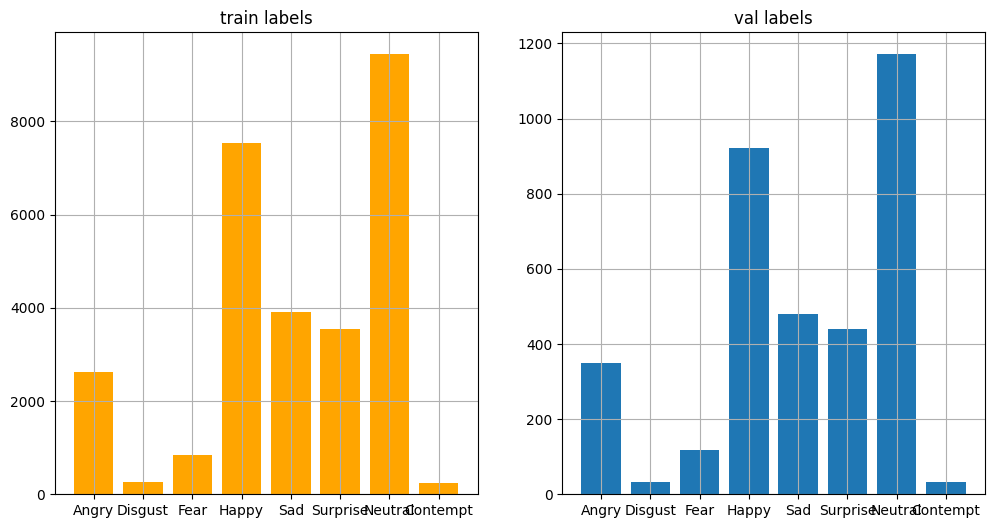

In [68]:
import matplotlib.pyplot as plt

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    _, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()
    
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')


In [71]:
print(train_labels[0])

[0. 0. 0. 0. 0. 0. 1. 0.]


In [ ]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral', 7: 'Contempt'}

In [73]:
def sum_labels(train_labels, val_labels, test_labels):
    # Convert lists to numpy arrays if they are not already
    train_labels = np.array(train_labels)
    val_labels = np.array(val_labels)
    test_labels = np.array(test_labels)
    
    # Sum up the labels
    total_sum = np.sum(train_labels, axis=0) + np.sum(val_labels, axis=0) + np.sum(test_labels, axis=0)
    
    return total_sum


result = sum_labels(train_labels, val_labels, test_labels)
print(result)

[ 3313.   348.  1043.  9353.  4821.  4445. 11859.   306.]


In [76]:
save_dir = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data"

np.save(os.path.join(save_dir, 'train_images.npy'), train_images)
np.save(os.path.join(save_dir, 'train_labels.npy'), train_labels)

np.save(os.path.join(save_dir, 'val_images.npy'), val_images)
np.save(os.path.join(save_dir, 'val_labels.npy'), val_labels)

np.save(os.path.join(save_dir, 'test_images.npy'), test_images)
np.save(os.path.join(save_dir, 'test_labels.npy'), test_labels)